<a href="https://colab.research.google.com/github/sanjitmathur/indigo_block_hours_model/blob/main/Block_Hours.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Overall On-Time Performance (OTP) for DEL-BOM sector: 57.20%
Block Hour Overrun Statistics by OTP Status (in hours):
| otp_status      | mean      | median   | std       |
|:----------------|:----------|:---------|:----------|
| Delayed (OTP=0) | 0.133178  | 0.12     | 0.0900101 |
| On-Time (OTP=1) | 0.0193182 | 0.02     | 0.0893863 |


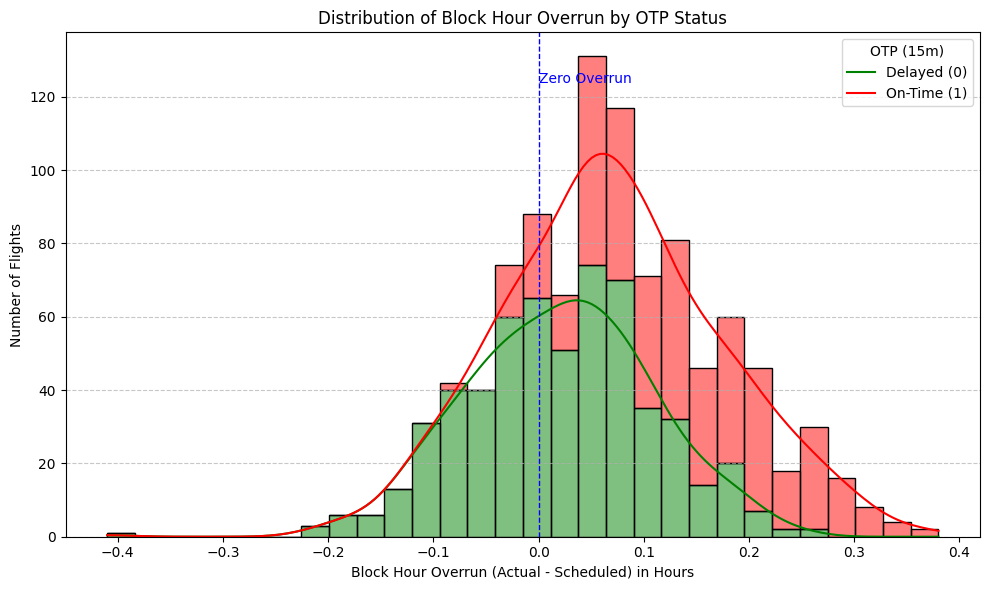

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

file_name = "/content/indigo_synthetic_DEL-BOM_last1year.csv"
df = pd.read_csv(file_name)

df['block_hour_overrun'] = df['actual_block_hours'] - df['scheduled_block_hours']

total_flights = len(df)
on_time_flights = df['otp_arrival_15m'].sum()
overall_otp = (on_time_flights / total_flights) * 100

print(f"Overall On-Time Performance (OTP) for DEL-BOM sector: {overall_otp:.2f}%")

overrun_stats = df.groupby('otp_arrival_15m')['block_hour_overrun'].agg(['mean', 'median', 'std']).reset_index()
overrun_stats['otp_status'] = overrun_stats['otp_arrival_15m'].replace({1: 'On-Time (OTP=1)', 0: 'Delayed (OTP=0)'})

print("Block Hour Overrun Statistics by OTP Status (in hours):")
print(overrun_stats[['otp_status', 'mean', 'median', 'std']].to_markdown(index=False, numalign="left", stralign="left"))

plt.figure(figsize=(10, 6))
sns.histplot(
    data=df,
    x='block_hour_overrun',
    hue='otp_arrival_15m',
    multiple='stack',
    bins=30,
    palette={1: 'green', 0: 'red'},
    kde=True
)
plt.title('Distribution of Block Hour Overrun by OTP Status')
plt.xlabel('Block Hour Overrun (Actual - Scheduled) in Hours')
plt.ylabel('Number of Flights')
plt.legend(title='OTP (15m)', labels=['Delayed (0)', 'On-Time (1)'])
plt.axvline(x=0, color='blue', linestyle='--', linewidth=1)
plt.text(0, plt.ylim()[1]*0.9, 'Zero Overrun', rotation=0, color='blue', ha='left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('block_hour_overrun_distribution.png')

In [2]:
correlation_cols = [
    'otp_arrival_15m',
    'actual_block_hours',
    'scheduled_block_hours',
    'block_hour_overrun',
    'dep_delay_min',
    'arr_delay_min',
    'weather_index',
    'atc_congestion_index',
    'wind_component_index',
    'load_factor'
]

correlation_matrix = df[correlation_cols].corr()
target_correlation = correlation_matrix['otp_arrival_15m'].sort_values(ascending=False)

print("Correlation with Target Variable 'otp_arrival_15m':")
print(target_correlation.to_markdown(numalign="left", stralign="left"))

X = df[['block_hour_overrun', 'dep_delay_min', 'aircraft_type', 'weather_index', 'atc_congestion_index']]
y = df['otp_arrival_15m']

X = pd.get_dummies(X, columns=['aircraft_type'], drop_first=True)

print("First 5 rows of prepared features (X) for modeling:")
print(X.head().to_markdown(index=False, numalign="left", stralign="left"))

Correlation with Target Variable 'otp_arrival_15m':
|                       | otp_arrival_15m   |
|:----------------------|:------------------|
| otp_arrival_15m       | 1                 |
| load_factor           | 0.0611615         |
| wind_component_index  | 0.025825          |
| scheduled_block_hours | -0.183624         |
| atc_congestion_index  | -0.213926         |
| weather_index         | -0.275265         |
| actual_block_hours    | -0.513412         |
| block_hour_overrun    | -0.532436         |
| dep_delay_min         | -0.571077         |
| arr_delay_min         | -0.792565         |
First 5 rows of prepared features (X) for modeling:
| block_hour_overrun   | dep_delay_min   | weather_index   | atc_congestion_index   | aircraft_type_A320neo   | aircraft_type_A321neo   |
|:---------------------|:----------------|:----------------|:-----------------------|:------------------------|:------------------------|
| 0.08                 | 7.9             | 0.249           | 0.334  

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

model = LogisticRegression(solver='liblinear', random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("-" * 50)
print(f"Model Accuracy on Test Set: {accuracy:.4f}")
print("\nClassification Report:")
print(report)

coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print("\nModel Coefficients (Impact on OTP=1 likelihood):")
print(coefficients.to_markdown(index=False, numalign="left", stralign="left"))

--------------------------------------------------
Model Accuracy on Test Set: 0.8800

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86        86
           1       0.88      0.91      0.90       114

    accuracy                           0.88       200
   macro avg       0.88      0.87      0.88       200
weighted avg       0.88      0.88      0.88       200


Model Coefficients (Impact on OTP=1 likelihood):
| Feature               | Coefficient   |
|:----------------------|:--------------|
| aircraft_type_A321neo | 0.275719      |
| aircraft_type_A320neo | 0.262259      |
| dep_delay_min         | -0.277166     |
| weather_index         | -0.541456     |
| atc_congestion_index  | -0.876178     |
| block_hour_overrun    | -8.45858      |


/tmp/ipython-input-1335877961.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-1335877961.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


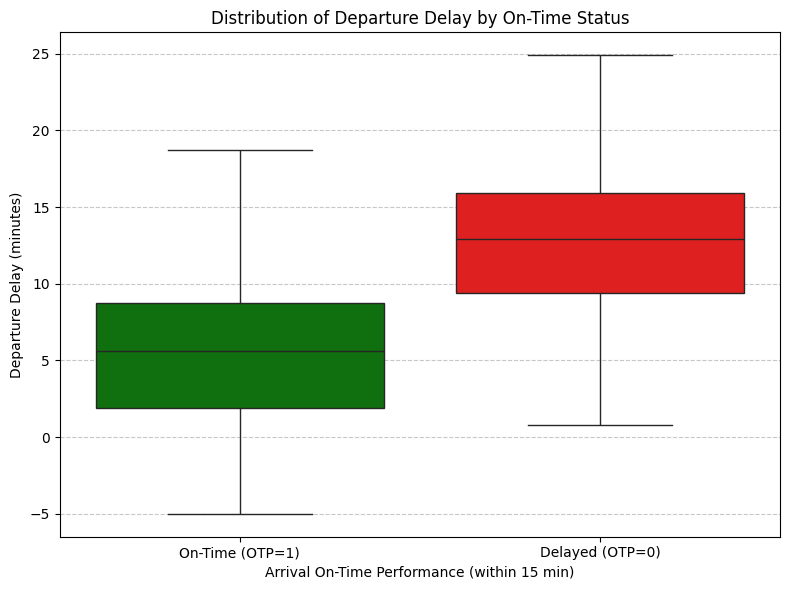

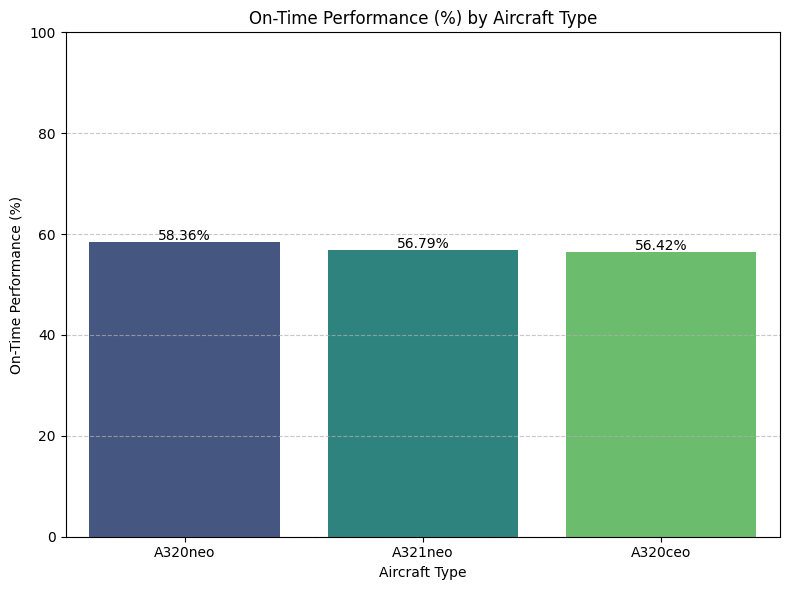

In [4]:
df['otp_status'] = df['otp_arrival_15m'].replace({1: 'On-Time (OTP=1)', 0: 'Delayed (OTP=0)'})

plt.figure(figsize=(8, 6))
sns.boxplot(
    data=df,
    x='otp_status',
    y='dep_delay_min',
    palette={'On-Time (OTP=1)': 'green', 'Delayed (OTP=0)': 'red'},
    showfliers=False
)
plt.title('Distribution of Departure Delay by On-Time Status')
plt.xlabel('Arrival On-Time Performance (within 15 min)')
plt.ylabel('Departure Delay (minutes)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('dep_delay_by_otp_boxplot.png')

otp_by_aircraft = df.groupby('aircraft_type')['otp_arrival_15m'].mean().sort_values(ascending=False) * 100

plt.figure(figsize=(8, 6))
sns.barplot(
    x=otp_by_aircraft.index,
    y=otp_by_aircraft.values,
    palette='viridis'
)
plt.title('On-Time Performance (%) by Aircraft Type')
plt.xlabel('Aircraft Type')
plt.ylabel('On-Time Performance (%)')

for index, value in enumerate(otp_by_aircraft.values):
    plt.text(index, value + 0.5, f'{value:.2f}%', ha='center')

plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('otp_by_aircraft_bar.png')